In [1]:
from math import sqrt,ceil,inf
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
import networkx as nx

import pickle
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

In [2]:
#FUNCTIONS TO SOLVE THE PROBLEM#

def findball(tree, center, radius):
    """Find all nodes within distance < radius from center."""
    visited = {center}
    queue = deque([(center, 0)])
    
    while queue:
        node, dist = queue.popleft()
        if dist < radius:
            for neighbor in tree[node]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, dist + 1))
    return visited

def compute_covering_brute(tree, r=0, burning=set(), burnt=set(), bn=inf):
    ''' Compute the best covering in brute force'''
    
    # If everything is covered
    if len(burning) == len(tree):
        return burnt, len(burnt)

    # Prune if we can't do better
    if len(burnt) >= bn:
        return set(tree.keys()), len(tree)

    best_covering = set(tree.keys())
    best_bn = bn

    to_choose = sorted(
        set(tree) - {b[0] for b in burnt},
        key=lambda node: -len(tree[node])  # sort by degree, descending
    )

    for node in to_choose:
        ball = findball(tree, node, r)
        new_burning = burning.union(ball)
        new_burnt = burnt.union({(node,r)})
        candidate_covering, candidate_bn = compute_covering_brute(tree, r + 1, new_burning, new_burnt, best_bn)

        if candidate_bn < best_bn:
            best_covering = candidate_covering
            best_bn = candidate_bn

    return best_covering, best_bn

In [3]:
#FUNCTIONS TO CREATE GRAPHS #

def build_adjacency_dict(h):
    """
    Converts a 2x(2 * number_of_edges) matrix into an adjacency dictionary.
    Parameters:
        h (list[list[int]]): A 2-row matrix representing edges between nodes.
                             Each column [a, b] indicates an edge between a and b.
    Returns:
        dict: A dictionary with each node as a key and a list of neighbors as values.
    """
    adjacency = {}
    for a, b in zip(h[0], h[1]):
        # Add b to a's list
        if a not in adjacency:
            adjacency[a] = []
        adjacency[a].append(b)
        # Add a to b's list (undirected assumption)
        if b not in adjacency:
            adjacency[b] = []
        adjacency[b].append(a)
    return adjacency

def to_adjacency(nodes,edges):
    '''Takes an int nodes and list of tuples edges and return adjacency form of the tree'''
    adj = {i:[] for i in range(nodes)}
    for (x,y) in edges:
        adj[x]+= [y]
        adj[y]+= [x]
    return adj
    
def graph_edges(tree):
    edges = []
    for node in tree:
        for adjacent in tree[node]:
            if (adjacent, node) not in edges:
                edges.append((node,adjacent))
    return edges
#first initialise the offspring distribution (zeta): p_0, p_1, ... p_k
def zeta_unspecified(randweight=10, tolerance=10**(-6)):
    T = 1
    p = []
    while T > 0:
        newp = random.random()/randweight
        if T >= newp:
            T = T - newp
            p.append(newp)
        else:
            p.append(T)
            T = 0
    assert(-tolerance <= sum(p) - 1 <= tolerance)
    return p


# a zeta where the expected number of children is 1, this is called a critical GW process
zeta_critical_example1 = [0.4, 0.3, 0.2, 0.1]
zeta_critical_example2 = [0.3, 0.4, 0.3]

##########################################################################################

#next we use the previous code to make a zeta and generate a GW tree of specified size n
def generate_GW(zeta, n, seed=None):
    if seed is not None:
        random.seed(seed)
        
    kidlist = list(range(len(zeta)))  # Values 0, 1, ..., max children
    edges = set()
    parent = 0
    upper = 1  # First unused node ID
    active_nodes = [0]  # List of nodes to expand (acts like a queue)

    while active_nodes and upper < n:
        parent = active_nodes.pop(0)
        nchild = random.choices(kidlist, weights=zeta, k=1)[0]

        for _ in range(nchild):
            if upper >= n:
                return (n, edges)
            edges.add((parent, upper))
            active_nodes.append(upper)
            upper += 1

    return (upper, edges)


In [4]:
#FUNCTIONS TO GENERATE GRAPHS#
def generate_uniform_tree(n):
    """
    Generate a uniform random tree on n nodes using a random Prufer sequence.
    Nodes are labeled 0 to n-1.
    """
    if n == 1:
        return nx.Graph()  # single node tree with no edges
    
    # Generate a random Prufer sequence of length n-2
    prufer_seq = [random.randint(0, n-1) for _ in range(n-2)]
    
    # Decode Prufer sequence into a tree (list of edges)
    # Algorithm adapted from Prufer sequence decoding:
    degree = [1] * n
    for node in prufer_seq:
        degree[node] += 1
    
    edges = []
    # Find the smallest node with degree 1
    leaf = 0
    while leaf < n and degree[leaf] != 1:
        leaf += 1
    
    for node in prufer_seq:
        edges.append((leaf, node))
        degree[leaf] -= 1
        degree[node] -= 1
        
        if degree[node] == 1 and node < leaf:
            leaf = node
        else:
            leaf += 1
            while leaf < n and degree[leaf] != 1:
                leaf += 1
    
    # Add the last edge
    u, v = [i for i in range(n) if degree[i] == 1]
    edges.append((u, v))
    
    # Create and return the tree graph
    tree = nx.Graph()
    tree.add_nodes_from(range(n))
    tree.add_edges_from(edges)
    return tree
edges = generate_uniform_tree(5).edges
adj = to_adjacency(5,edges)
print(edges)
print(adj)

[(0, 4), (1, 3), (1, 4), (2, 4)]
{0: [4], 1: [3, 4], 2: [4], 3: [1], 4: [0, 1, 2]}


In [5]:
# Define the functions from the last cell
def plot_tree(edges):
    def get_positions(node, depth=0, pos={}, x=0, dx=1):
        if node not in pos:
            pos[node] = (x, -depth)
            children = [v for u, v in edges if u == node]
            if children:
                dx = dx / len(children)
                next_x = x - dx * (len(children) - 1) / 2
                for i, child in enumerate(children):
                    pos = get_positions(child, depth + 1, pos, next_x + i * dx, dx)
        return pos

    def draw_tree(ax, edges, pos):
        for u, v in edges:
            x_values = [pos[u][0], pos[v][0]]
            y_values = [pos[u][1], pos[v][1]]
            ax.plot(x_values, y_values, 'gray')

        for node, (x, y) in pos.items():
            ax.scatter(x, y, c='skyblue', s=100)
            ax.text(x, y, str(node), fontsize=12, ha='center', va='center')

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_axis_off()

    root = 0
    pos = get_positions(root)
    draw_tree(ax, edges, pos)

    plt.show()


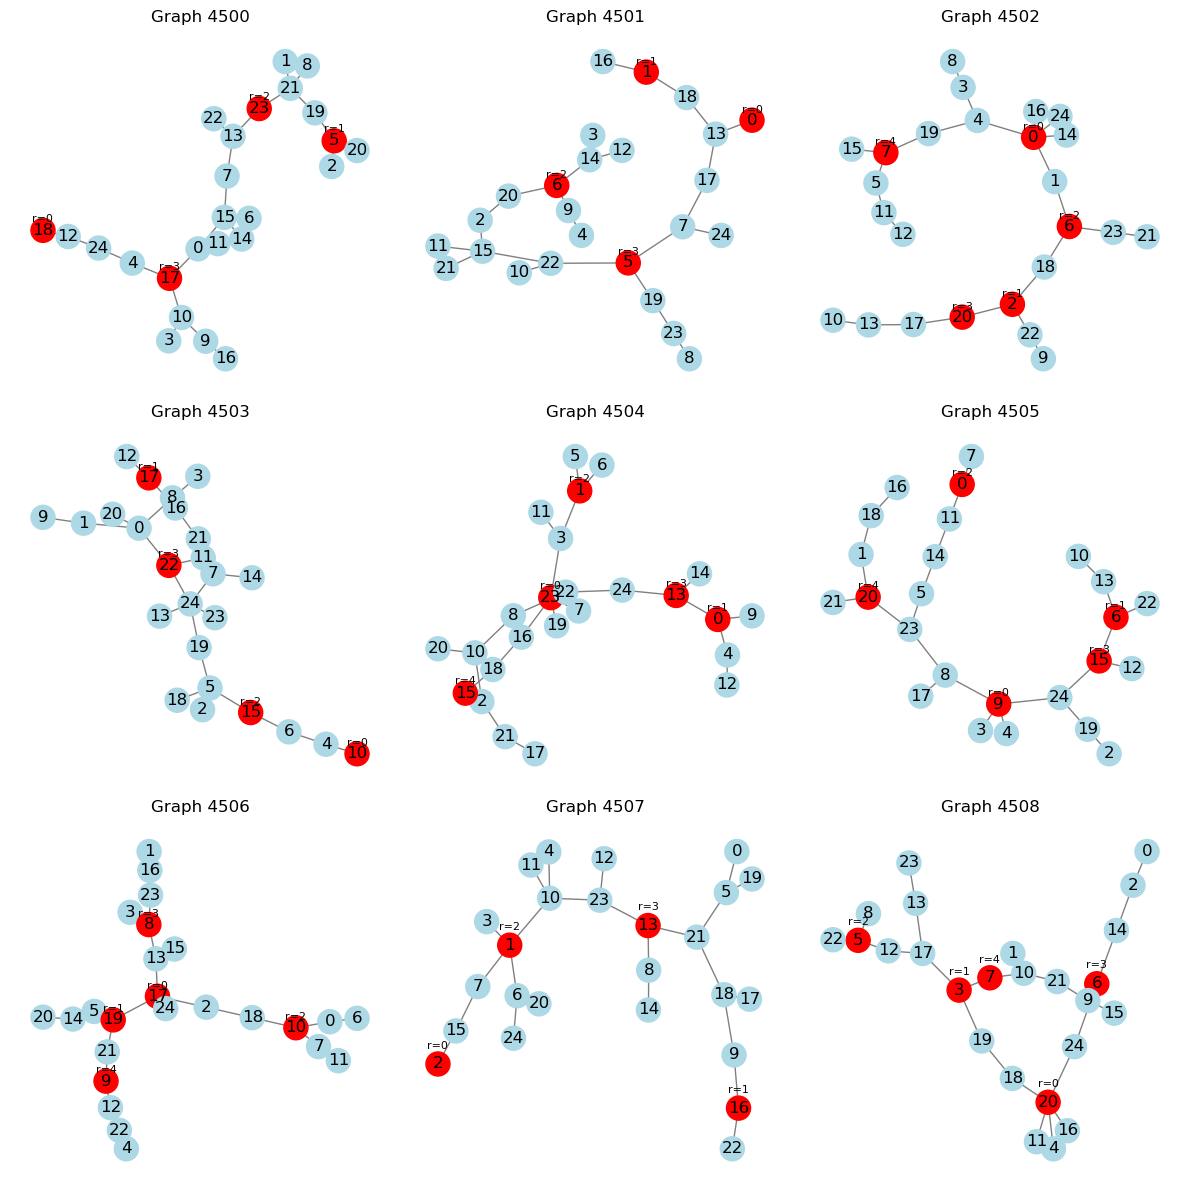

In [9]:
#EXAMPLES OF GRAPHS#

instances = 4500
with open('data_5000.pkl', 'rb') as file:
    X, y = pickle.load(file)

edges = [graph_edges(X[i]) for i in range(instances, instances+9)]
trees = [nx.Graph(edge) for edge in edges]

plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    G = trees[i]
    pos = nx.spring_layout(G, seed=42)
    
    # Get ball centers and radii
    ball_info = y[instances + i]  # set of (node, radius)
    
    # Compute all nodes covered by any ball
    covered_nodes = set()
    for center, radius in ball_info:
        reachable = nx.single_source_shortest_path_length(G, center, cutoff=radius)
        covered_nodes.update(reachable.keys())
    
    # Build color map:
    node_colors = []
    for node in G.nodes:
        if node in dict(ball_info):  # Ball center
            node_colors.append('red')
        elif node in covered_nodes:
            node_colors.append('lightblue')
        else:
            node_colors.append('grey')
    
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray')

    # Annotate ball centers with radius
    for center, radius in ball_info:
        x, y_pos = pos[center]
        plt.text(x, y_pos + 0.05, f"r={radius}", fontsize=8, ha='center', color='black')
    
    plt.title(f"Graph {instances + i}")
    plt.axis('off')

plt.tight_layout()
plt.show()
counts = [X.count(X[i]) for i in range(len(X))]

In [30]:

i=10
with open('data_5000.pkl', 'rb') as file:
    X, y = pickle.load(file)

edges = [graph_edges(X[i])]
trees = [nx.Graph(edge) for edge in edges]

plt.figure(figsize=(12, 12))

G = trees[i]
pos = nx.spring_layout(G, seed=42)

# Get ball centers and radii
ball_info = sorted(y[i], key=lambda x: x[1])  # Sort by radius
centers, radii = zip(*ball_info)
centers = list(centers)
radii = list(radii)

for j in range (len(centers)):
    # Build color map:
    node_colors = []
    for node in G.nodes:
        if node in (centers[:j]):  # Ball center
            node_colors.append('red')
        else:
            node_colors.append('lightblue')

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray')
    
    # Annotate ball centers with radius
    for center, radius in ball_info:
        x, y_pos = pos[center]
        plt.text(x, y_pos + 0.05, f"r={radius}", fontsize=8, ha='center', color='black')
    
    plt.title(f"Graph {j}")
    
    
    plt.tight_layout()
    
    plt.savefig(f"graph_intro_{j}.png",dpi=300)
    plt.show()
        




IndexError: list index out of range

<Figure size 1200x1200 with 0 Axes>

In [7]:
#CREATING OUR DATA#

# Execute the final cell to reproduce the error
n = 25
bn = ceil(sqrt(n))
Trees = X
print(Trees[-1])
labels = y
data_size = 2000

lambda_ = 0.92
k_values = np.arange(0, 11)
zeta = poisson.pmf(k_values, mu=lambda_)
print(zeta)
print(bn-1)
while len(Trees)<data_size:
    tree = to_adjacency(n,generate_uniform_tree(n).edges())
    covering,best_bn = compute_covering_brute(tree)
    Trees.append(tree)
    labels.append(covering)
X = Trees
y = labels



{0: [16], 1: [13, 5], 2: [18, 20, 13], 3: [22], 4: [12, 5], 5: [1, 4, 9], 6: [22], 7: [24], 8: [13], 9: [5, 10, 24], 10: [9, 17, 19], 11: [15], 12: [4, 15], 13: [1, 2, 8, 21], 14: [21], 15: [11, 12], 16: [0, 20], 17: [10], 18: [2], 19: [10, 22, 23], 20: [2, 16], 21: [13, 14], 22: [3, 6, 19], 23: [19], 24: [7, 9]}
[3.98519041e-01 3.66637518e-01 1.68653258e-01 5.17203325e-02
 1.18956765e-02 2.18880447e-03 3.35616686e-04 4.41096215e-05
 5.07260648e-06 5.18533107e-07 4.77050458e-08]
4


In [50]:
#CREATING OUR MODEL#

class GNN(nn.Module):
    def __init__(self,din,dh,n_p):
        super().__init__()
        self.dh = dh
        self.din = din
        self.n_p = n_p
        
        # Encoder:
        self.W_E = nn.Linear(din + dh, dh, bias=True)


        # Message passing :
        self.W_M = nn.ModuleList([nn.Linear(2*dh,dh, bias=True) for _ in range(n_p)])
        self.W_P = nn.ModuleList([nn.Linear(2*dh,dh,bias=True) for _ in range(n_p)])

        # Decoder
        self.W_D = nn.Linear(2*dh,1,bias=True)

    def forward(self,x,h,edge_index):
        
        n = x.shape[0]
        # encode
        z = self.W_E(torch.cat([x,h],dim=1)) 
        h = z.clone()
        # GNN, message passing
        for k in range(self.n_p):
            h_i = h[edge_index[0]]
            h_j = h[edge_index[1]]

            m = F.relu(self.W_M[k](torch.cat([h_i,h_j],dim = 1) ))
            m_max = torch.zeros_like(h) - float('inf')  # initialize with -inf
            m_max = m_max.scatter_reduce(0, edge_index[0].unsqueeze(-1).expand_as(m), m, reduce='amax', include_self=False)
            
            # Replace -inf by zeros for nodes with no incoming edges
            m_max = torch.where(m_max == float('-inf'), torch.tensor(0.), m_max)
            h = h + F.relu(self.W_P[k](torch.cat([h,m_max], dim = 1)))
        # decode
        l = self.W_D(torch.cat([z,h], dim=1)).squeeze(-1)

        # if the first element is one
        mask = (x[:,0] == 1)
        l[mask] = -inf

        p = F.softmax(l,dim = 0)

        return p, h

        
        

In [51]:
#FUNCTIONS TO DEFINE RIGHT INPUTS INTO OUR MODEL#

def encode_cover(sol,n,din):
    '''given a partial solution sol, will output the coresponding X matrix'''
    
    x = np.zeros((n,din),dtype = 'i')
    if len(sol) == 0:
        return torch.tensor(x, dtype=torch.float)
    for center,r in sol:
        x[center][0] = 1
        x[center][1] = r
    x = torch.tensor(x, dtype=torch.float)
    return x


def adjacency_to_edge_index(adj_dict):
    edges = set()
    for u, neighbors in adj_dict.items():
        for v in neighbors:
            if u <= v:  # Add each edge once (sorted order)
                edges.add((u, v))
            else:
                edges.add((v, u))

    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()
    return edge_index

    
def adjacency_dict_to_nx(adj_dict):
    """
    Convert adjacency dictionary (undirected) to a NetworkX Graph.
    
    Args:
        adj_dict: dict where keys are nodes and values are iterables of neighbors
    
    Returns:
        G: networkx.Graph
    """
    G = nx.Graph()
    for node, neighbors in adj_dict.items():
        for nbr in neighbors:
            G.add_edge(node, nbr)  # automatically adds nodes if needed
    return G

def get_initial_h(G: nx.Graph, dh: int, n_eigvec: int = 5) -> torch.Tensor:
    """
    Initialize hidden states `h` for nodes in graph G by combining
    structural features with Laplacian spectral embeddings.

    Args:
        G: networkx Graph
        dh: hidden dimension size
        n_eigvec: number of Laplacian eigenvectors to include (excluding trivial one)
        device: torch device

    Returns:
        h: torch.Tensor of shape (n_nodes, dh)
    """
    n = G.number_of_nodes()

    # Sort nodes for deterministic ordering
    nodes = sorted(G.nodes())

    # Basic graph features
    degree = np.array([G.degree(node) for node in nodes], dtype=np.float32)
    clustering = np.array([nx.clustering(G, node) for node in nodes], dtype=np.float32)
    pagerank = np.array([nx.pagerank(G)[node] for node in nodes], dtype=np.float32)

    # Stack basic features: shape (n_nodes, 3)
    features = np.stack([degree, clustering, pagerank], axis=1)

    # Compute normalized Laplacian matrix
    A = nx.adjacency_matrix(G, nodelist=nodes)
    L = csgraph.laplacian(A, normed=True)

    # Compute k smallest eigenvectors (skip first one later)
    k = min(n_eigvec + 1, n - 1)  # Ensure k < n
    eigenvalues, eigenvectors = eigsh(L, k=k, which='SM')

    # Sort by eigenvalue to ensure consistency
    idx = np.argsort(eigenvalues)
    eigenvectors = eigenvectors[:, idx]

    # Drop the first trivial eigenvector (corresponding to eigenvalue ~0)
    spectral_feats = eigenvectors[:, 1:n_eigvec + 1]

    # Align signs for determinism (optional, but useful)
    spectral_feats *= np.sign(spectral_feats[0, :])

    # Combine basic features with spectral embeddings
    all_feats = np.hstack([features, spectral_feats])

    # Normalize features (mean=0, std=1)
    all_feats = (all_feats - all_feats.mean(axis=0)) / (all_feats.std(axis=0) + 1e-6)

    # Convert to tensor
    all_feats = torch.tensor(all_feats, dtype=torch.float32)

    # Pad with zeros if dh > current dimension
    if dh != all_feats.shape[1]:
        pad_size = dh - all_feats.shape[1]
        if pad_size > 0:
            padding = torch.zeros(all_feats.shape[0], pad_size)
            h = torch.cat([all_feats, padding], dim=1)
        else:
            h = all_feats[:, :dh]  # Truncate if too many features
    else:
        h = all_feats

    return h

In [52]:
din = 2       # input feature size
dh = 32       # hidden dimension
n_p = 4     # number of GNN steps
n = 25
batch_size = 8
D = [(X[i],y[i]) for i in range(len(X))]

In [ ]:
#TRAINING OUR MODEL#

model = GNN(din, dh, n_p)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(50):
    print(epoch)
    total_loss = 0
    for tree, cover in D:  # your dataset
        cover = {r: center for (center, r) in cover}
        edge_index = adjacency_to_edge_index(tree)

        h = get_initial_h(adjacency_dict_to_nx(tree), dh)

        loss = 0
        for i in range(0,len(cover)):
            partial_cover = {(center, r) for (r, center) in cover.items() if r < i}
            next_center = cover[i]

            x = encode_cover(partial_cover, n, din)

            p, h = model(x, h, edge_index)

            loss += -torch.log(p[next_center] + 1e-8)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}, loss: {total_loss}")


0


In [ ]:
tree,cover = D[5]
treenx = adjacency_dict_to_nx(tree)
nx.draw(treenx, with_labels=True )
cover = {r: center for (center, r) in cover}
print(cover)
edge_index = adjacency_to_edge_index(tree)

h = torch.zeros(n,dh)

for i in range(len(cover)-1,0,-1):
    partial_cover = {(center, r) for (r, center) in cover.items() if r > i}
    print(partial_cover)
    next_center = cover[i]

    x = encode_cover(partial_cover, n, din)
    
    x = x

    h = h

    p, h = model(x, h, edge_index)
    print(p)

True cover: {0: 1, 3: 6, 1: 10, 2: 7}
tensor([0.0193, 0.0190, 0.0195, 0.0562, 0.0562, 0.0562, 0.0193, 0.0188, 0.0188,
        0.0198, 0.0198, 0.0198, 0.0198, 0.0562, 0.0562, 0.0198, 0.0562, 0.0562,
        0.0562, 0.0562, 0.0562, 0.0562, 0.0562, 0.0562, 0.0562],
       grad_fn=<SoftmaxBackward0>)
Step 0: predicted node = 24, score = 0.0562
tensor([0.0512, 0.0517, 0.0525, 0.0460, 0.0460, 0.0460, 0.0521, 0.0482, 0.0534,
        0.0195, 0.0195, 0.0195, 0.0195, 0.0460, 0.0460, 0.0153, 0.0460, 0.0460,
        0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0000],
       grad_fn=<SoftmaxBackward0>)
Step 1: predicted node = 8, score = 0.0534
tensor([0.0366, 0.1278, 0.0332, 0.0009, 0.0009, 0.0009, 0.5729, 0.1469, 0.0000,
        0.0141, 0.0141, 0.0141, 0.0141, 0.0009, 0.0009, 0.0148, 0.0009, 0.0009,
        0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0000],
       grad_fn=<SoftmaxBackward0>)
Step 2: predicted node = 6, score = 0.5729
tensor([5.2738e-03, 5.9711e-01, 2.7267e-03, 1.4590e-

/tmp/ipykernel_634663/2774786681.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


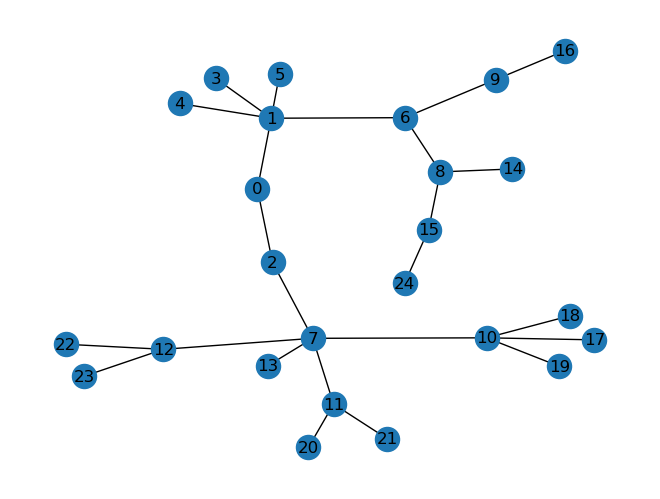

In [58]:
tree, raw_cover = D[0]

# Convert to NetworkX graph and draw
tree_nx = adjacency_dict_to_nx(tree)
nx.draw(tree_nx, with_labels=True)

# Reformat cover as {radius: center}
cover = {radius: center for center, radius in raw_cover}
print("True cover:", cover)

# Prepare edge index for the model
edge_index = adjacency_to_edge_index(tree)

# Get initial node embeddings h
h = torch.zeros(n,dh)

# Initialize partial cover
partial_cover = set()

# Run inference for each cover element
for i in range(len(cover)):
    # Encode the current partial cover
    x = encode_cover(partial_cover, n, din)
    x = torch.tensor(x, dtype=torch.float32)

    # Run the model
    p, h = model(x, h, edge_index)
    print(p)
    # Get the predicted node
    predicted_node = torch.argmax(p).item()
    partial_cover.add((predicted_node, i))

    print(f"Step {i}: predicted node = {predicted_node}, score = {p[predicted_node].item():.4f}")

# Final output
print("True cover:", cover)
print("Predicted partial cover:", partial_cover)
